In [ ]:
import zipfile
from tqdm.notebook import tqdm

with zipfile.ZipFile('/content/drive/MyDrive/Pubtab.zip', 'r') as zip_ref:
    for member in tqdm(zip_ref.infolist(), desc='Extracting Pubtab'):
        try:
            zip_ref.extract(member, '/content/pubtab')
        except zipfile.error as e:
            print(f'Error extracting {member.filename}: {e}')


In [ ]:
!pip install pdf2image
!apt-get install poppler-utils
!pip install easyocr

import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
import easyocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.6).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB

In [ ]:

# Step 1: Dataset Preparation
class TableDataset(Dataset):
    def __init__(self, image_folder, label_folder, transform=None):
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.transform = transform
        self.image_files = sorted(os.listdir(image_folder))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.image_files[idx])
        label_path = os.path.join(self.label_folder, self.image_files[idx].replace('.jpg', '.txt'))

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        labels = torch.zeros(3)  # Three classes (table row, column, spanning cell)
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    class_id = int(line.strip().split()[0])
                    labels[class_id] = 1  # One-hot encoding for multi-label classification

        return image, labels

In [ ]:
# Define transforms
# Define transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [ ]:
# Load dataset
train_dataset = TableDataset('/content/pubtab/pubtab_110k_yolo/images/train', '/content/pubtab/pubtab_110k_yolo/labels/train', transform=transform)
val_dataset = TableDataset('/content/pubtab/pubtab_110k_yolo/images/val', '/content/pubtab/pubtab_110k_yolo/labels/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # Reduce batch size to save memory
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [ ]:
class TableCNN(nn.Module):
    def __init__(self):
        super(TableCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # Adjust based on input size
        self.fc2 = nn.Linear(128, 3)  # 3 classes (multi-label)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))  # Multi-label classification
        return x

In [ ]:
# Initialize Model
model = TableCNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


TableCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
# Define Loss and Optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy for multi-label classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:

# Step 3: Train Model
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')
        validate_model(model, val_loader)

In [ ]:

# Step 4: Validate Model
def validate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = (outputs > 0.5).float()  # Convert sigmoid output to binary labels
            correct += (predicted == labels).sum().item()
            total += labels.numel()

    print(f'Validation Accuracy: {100 * correct / total:.2f}%')

In [31]:

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)

100%|██████████| 5000/5000 [25:07<00:00,  3.32it/s]


Epoch 1, Loss: 0.15833263472542167
Validation Accuracy: 92.87%


100%|██████████| 5000/5000 [25:00<00:00,  3.33it/s]


Epoch 2, Loss: 0.11620866706967353
Validation Accuracy: 93.50%


100%|██████████| 5000/5000 [24:37<00:00,  3.38it/s]


Epoch 3, Loss: 0.0979190459783189
Validation Accuracy: 94.03%


100%|██████████| 5000/5000 [24:49<00:00,  3.36it/s]


Epoch 4, Loss: 0.08446699227979407
Validation Accuracy: 94.21%


100%|██████████| 5000/5000 [24:43<00:00,  3.37it/s]


Epoch 5, Loss: 0.0708785355033353
Validation Accuracy: 94.22%


In [32]:
model_path = '/content/drive/MyDrive/table_cnn_model.pth'
torch.save(model.state_dict(), model_path)

In [50]:
from torchsummary import summary

# Display the model summary
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
         MaxPool2d-2           [-1, 16, 64, 64]               0
            Conv2d-3           [-1, 32, 64, 64]           4,640
         MaxPool2d-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,496
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Linear-7                  [-1, 128]       2,097,280
            Linear-8                    [-1, 3]             387
           Sigmoid-9                    [-1, 3]               0
Total params: 2,121,251
Trainable params: 2,121,251
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 4.38
Params size (MB): 8.09
Estimated Total Size (MB): 12.66
--------------------------------------

In [46]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import easyocr

# Step 4: Validate Model on 5 Test Images with Bounding Boxes
def validate_model_on_test_samples_with_bboxes(model, test_loader):
    model.eval()

    # Select 5 random samples
    random_samples = random.sample(list(test_loader), 5)

    reader = easyocr.Reader(['en'])  # Initialize EasyOCR

    for idx, (images, labels) in enumerate(random_samples):
        images, labels = images.to(device), labels.to(device)

        # Make predictions
        outputs = model(images)
        predicted = (outputs > 0.5).float()  # Convert sigmoid output to binary labels

        # Calculate accuracy, precision, recall, F1 for each sample
        accuracy = (predicted == labels).sum().item() / labels.numel()
        print(f"Test Sample {idx + 1}:")
        print(f"Ground Truth Labels: {labels}")
        print(f"Predicted Labels: {predicted}")
        print(f"Accuracy: {accuracy:.2f}")

        # Convert the image tensor to a numpy array (HWC format for visualization)
        img = images[0].cpu().numpy().transpose(1, 2, 0)
        img = (img * 255).astype(np.uint8)  # Convert to uint8 format for OpenCV

        # Use EasyOCR to extract text and get bounding boxes
        result = reader.readtext(img)

        # Draw bounding boxes on the image
        for (bbox, text, prob) in result:
            pts = np.array(bbox, dtype=np.int32)  # Get the bounding box points
            pts = pts.reshape((-1, 1, 2))
            cv2.polylines(img, [pts], isClosed=True, color=(0, 255, 0), thickness=2)
            # Optional: Draw the text on top of the bounding box
            cv2.putText(img, text, tuple(pts[0][0]), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

        # Visualize the image with bounding boxes and the predicted labels
        plt.figure(figsize=(5, 5))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert to RGB for proper display in matplotlib
        plt.title(f"Prediction: {predicted.cpu().numpy()[0]}")
        plt.show()






Test Sample 1:
Ground Truth Labels: tensor([[1., 1., 0.]])
Predicted Labels: tensor([[1., 1., 0.]])
Accuracy: 1.00


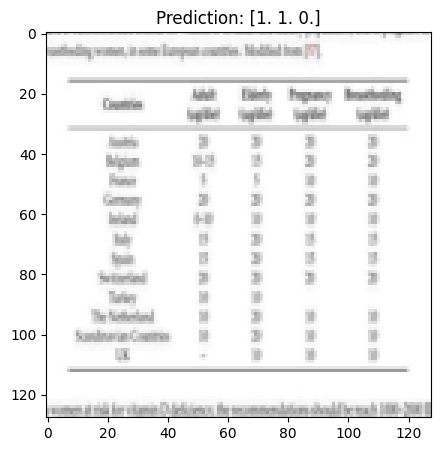

Test Sample 2:
Ground Truth Labels: tensor([[1., 1., 0.]])
Predicted Labels: tensor([[1., 1., 0.]])
Accuracy: 1.00


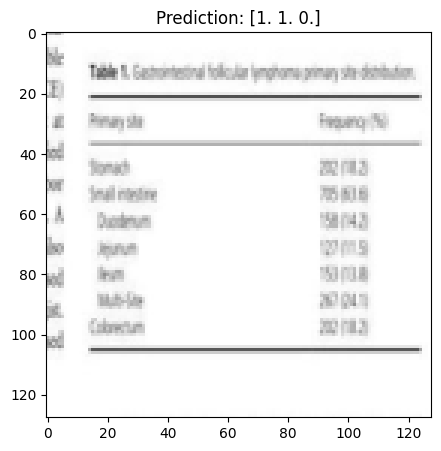

Test Sample 3:
Ground Truth Labels: tensor([[1., 1., 1.]])
Predicted Labels: tensor([[1., 1., 1.]])
Accuracy: 1.00


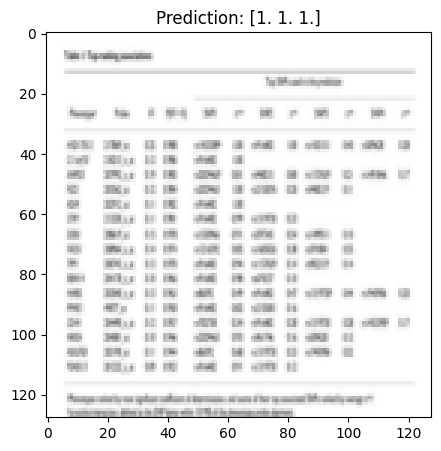

Test Sample 4:
Ground Truth Labels: tensor([[1., 1., 0.]])
Predicted Labels: tensor([[1., 1., 1.]])
Accuracy: 0.67


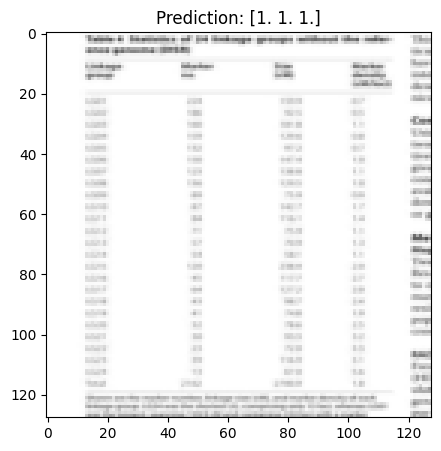

Test Sample 5:
Ground Truth Labels: tensor([[1., 1., 0.]])
Predicted Labels: tensor([[1., 1., 0.]])
Accuracy: 1.00


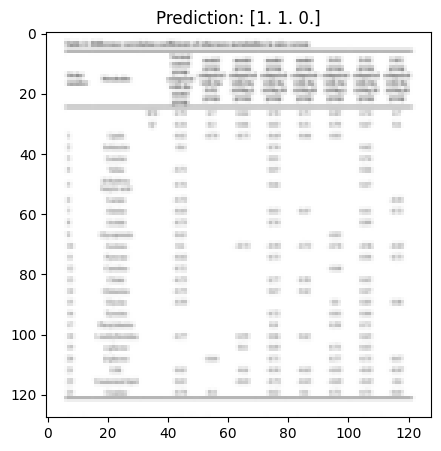

In [47]:
# Load test dataset
test_dataset = TableDataset('/content/pubtab/pubtab_110k_yolo/images/test', '/content/pubtab/pubtab_110k_yolo/labels/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# After training is completed, call the validation function on the test samples
validate_model_on_test_samples_with_bboxes(model, test_loader)

In [53]:
import pandas as pd

# Step 5: Extract Tables from PDF and Annotate with Bounding Boxes and Output Table Data
def extract_tables_and_annotate_bboxes(pdf_path, model):
    # Convert PDF pages to images
    images = convert_from_path(pdf_path)

    reader = easyocr.Reader(['en'])  # Initialize EasyOCR

    for page_num, img in enumerate(images):
        # Convert image to the same format as used for model input
        img_array = np.array(img)
        img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

        # Resize and prepare image for the model prediction
        transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])
        img_tensor = transform(img).unsqueeze(0).to(device)

        # Get model predictions
        outputs = model(img_tensor)
        predicted = (outputs > 0.5).float()  # Convert sigmoid output to binary labels

        detected_classes = []
        class_names = ['Table Row', 'Table Column', 'Spanning Cell']
        for idx, class_id in enumerate(predicted[0]):
            if class_id == 1:
                detected_classes.append(class_names[idx])

        # Extract text and bounding boxes using EasyOCR
        result = reader.readtext(img_rgb)

        # Create a list to hold the extracted data in tabular form
        extracted_data = []

        # Draw bounding boxes on the image and collect text data
        for (bbox, text, prob) in result:
            # Store the bounding box, detected text, and probability in the extracted data list
            extracted_data.append({
                "Bounding Box": bbox,
                "Text": text,
                "Confidence": prob
            })

            # Draw the bounding box on the image
            pts = np.array(bbox, dtype=np.int32)
            pts = pts.reshape((-1, 1, 2))
            cv2.polylines(img_rgb, [pts], isClosed=True, color=(0, 255, 0), thickness=2)
            # Draw the detected text on the image
            cv2.putText(img_rgb, text, tuple(pts[0][0]), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

        # Visualize the image with bounding boxes and predicted labels
        plt.figure(figsize=(10, 10))
        plt.imshow(img_rgb)
        plt.title(f"Page {page_num + 1} - Detected Table Structure: {', '.join(detected_classes)}")
        plt.show()

        # Convert the extracted data to a pandas DataFrame for structured output
        extracted_df = pd.DataFrame(extracted_data)

        # Display the extracted table data
        print(f"\nExtracted Data from Page {page_num + 1}:")
        display(extracted_df)

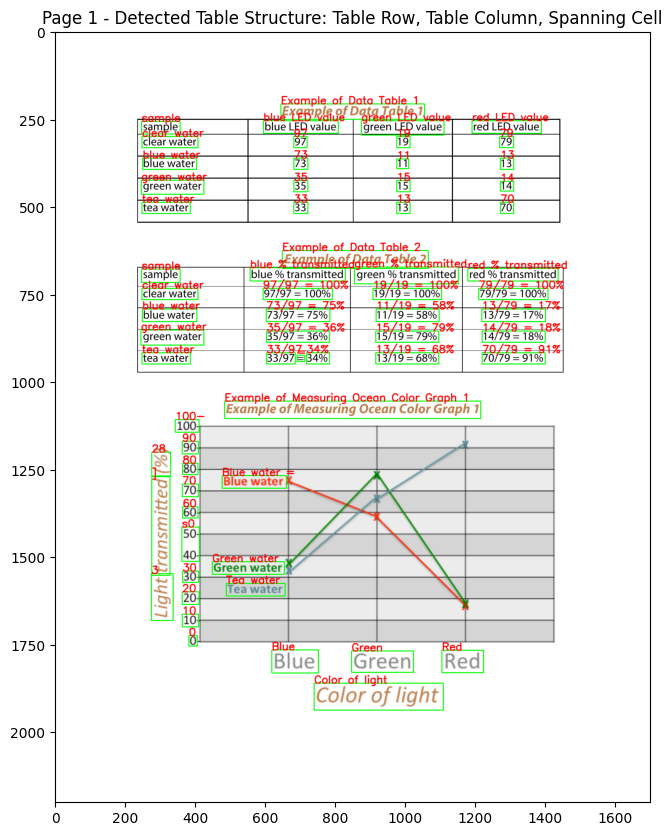


Extracted Data from Page 1:


,Bounding Box,Text,Confidence
0,"[[645, 205], [1055, 205], [1055, 249], [645, 2...",Example of Data Table 1,0.801629
1,"[[247, 255], [357, 255], [357, 291], [247, 291]]",sample,0.999829
2,"[[595, 253], [809, 253], [809, 289], [595, 289]]",blue LED value,0.925107
3,"[[875, 253], [1111, 253], [1111, 294], [875, 2...",green LED value,0.992673
4,"[[1191, 253], [1389, 253], [1389, 289], [1191,...",red LED value,0.572885
...,...,...,...
60,"[[382, 1724], [406, 1724], [406, 1754], [382, ...",0,0.999982
61,"[[619, 1765], [752, 1765], [752, 1831], [619, ...",Blue,0.999995
62,"[[847, 1768], [1024, 1768], [1024, 1829], [847...",Green,0.660984
63,"[[1105, 1766], [1224, 1766], [1224, 1830], [11...",Red,0.842461


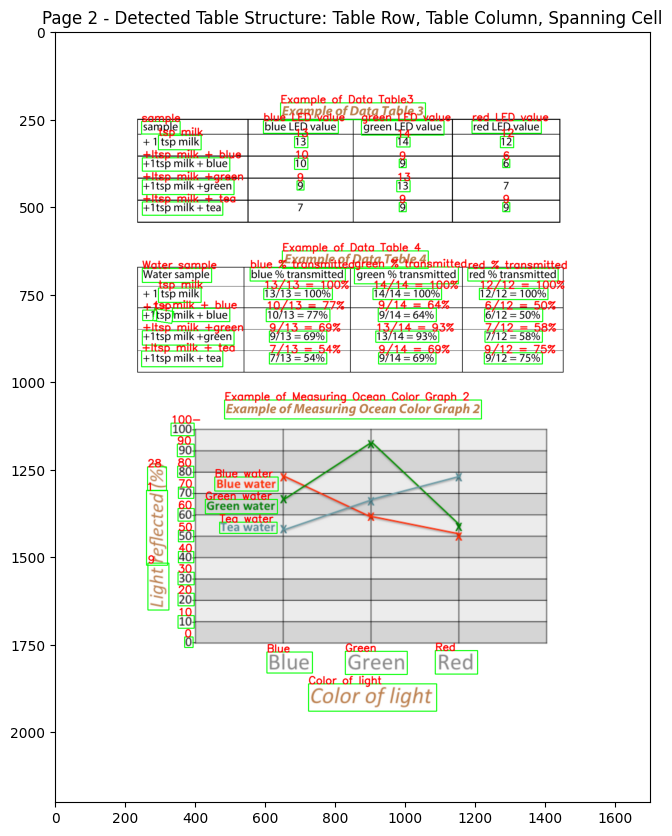


Extracted Data from Page 2:


,Bounding Box,Text,Confidence
0,"[[644, 202], [1058, 202], [1058, 250], [644, 2...",Example of Data Table3,0.847512
1,"[[247, 255], [357, 255], [357, 291], [247, 291]]",sample,0.999829
2,"[[595, 253], [809, 253], [809, 289], [595, 289]]",blue LED value,0.925107
3,"[[875, 253], [1111, 253], [1111, 294], [875, 2...",green LED value,0.992673
4,"[[1191, 253], [1389, 253], [1389, 289], [1191,...",red LED value,0.572885
...,...,...,...
59,"[[605, 1771], [735, 1771], [735, 1831], [605, ...",Blue,0.999995
60,"[[829, 1769], [1006, 1769], [1006, 1835], [829...",Green,0.702551
61,"[[1086, 1767], [1207, 1767], [1207, 1834], [10...",Red,0.999999
62,"[[724, 1862], [1090, 1862], [1090, 1940], [724...",Color of light,0.951849


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [55]:
# Example Usage1
extract_tables_and_annotate_bboxes('table2.pdf', model)

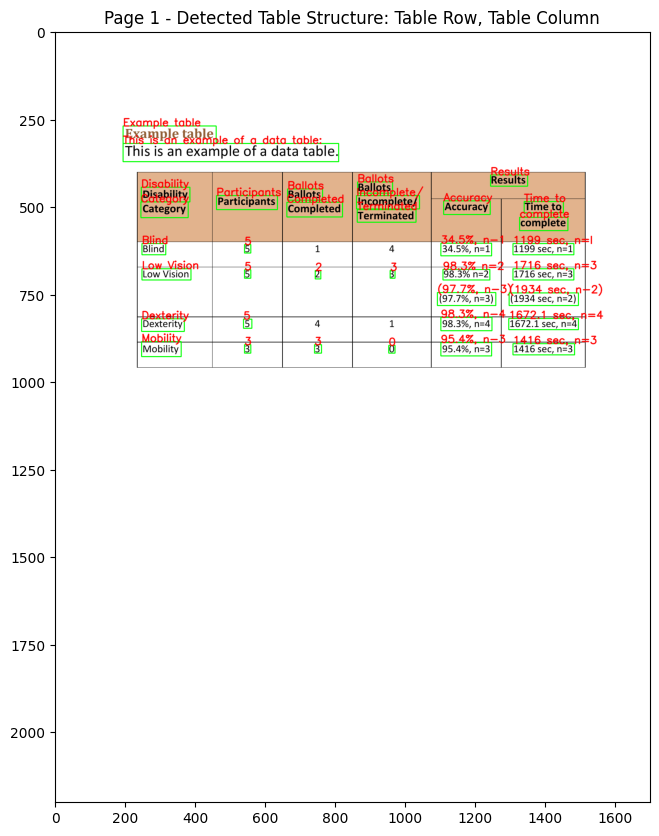


Extracted Data from Page 1:


,Bounding Box,Text,Confidence
0,"[[194, 268], [460, 268], [460, 318], [194, 318]]",Example table,0.790203
1,"[[194, 318], [810, 318], [810, 370], [194, 370]]",This is an example of a data table:,0.578539
2,"[[1244, 408], [1350, 408], [1350, 440], [1244,...",Results,0.999997
3,"[[864, 428], [964, 428], [964, 460], [864, 460]]",Ballots,0.985694
4,"[[246, 443], [385, 443], [385, 485], [246, 485]]",Disability,0.999857
5,"[[664, 448], [764, 448], [764, 480], [664, 480]]",Ballots,0.988794
6,"[[245, 485], [380, 485], [380, 530], [245, 530]]",Category,0.969673
7,"[[461, 467], [635, 467], [635, 507], [461, 507]]",Participants,0.940834
8,"[[662, 486], [821, 486], [821, 528], [662, 528]]",Completed,0.955106
9,"[[861, 467], [1041, 467], [1041, 505], [861, 5...",Incomplete/,0.924884


In [56]:
# Example Usage2
extract_tables_and_annotate_bboxes('table.pdf', model)